In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

### Import train and test data

In [62]:
train_data =  pd.read_csv('../Data/train_2v.csv',index_col='id')
train_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [63]:
test_data =  pd.read_csv('../Data/test_2v.csv',index_col='id')
test_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


In [64]:
print(train_data.shape)
print(test_data.shape)

(43400, 11)
(18601, 10)


## Exploratery analysis

##### Correlation map

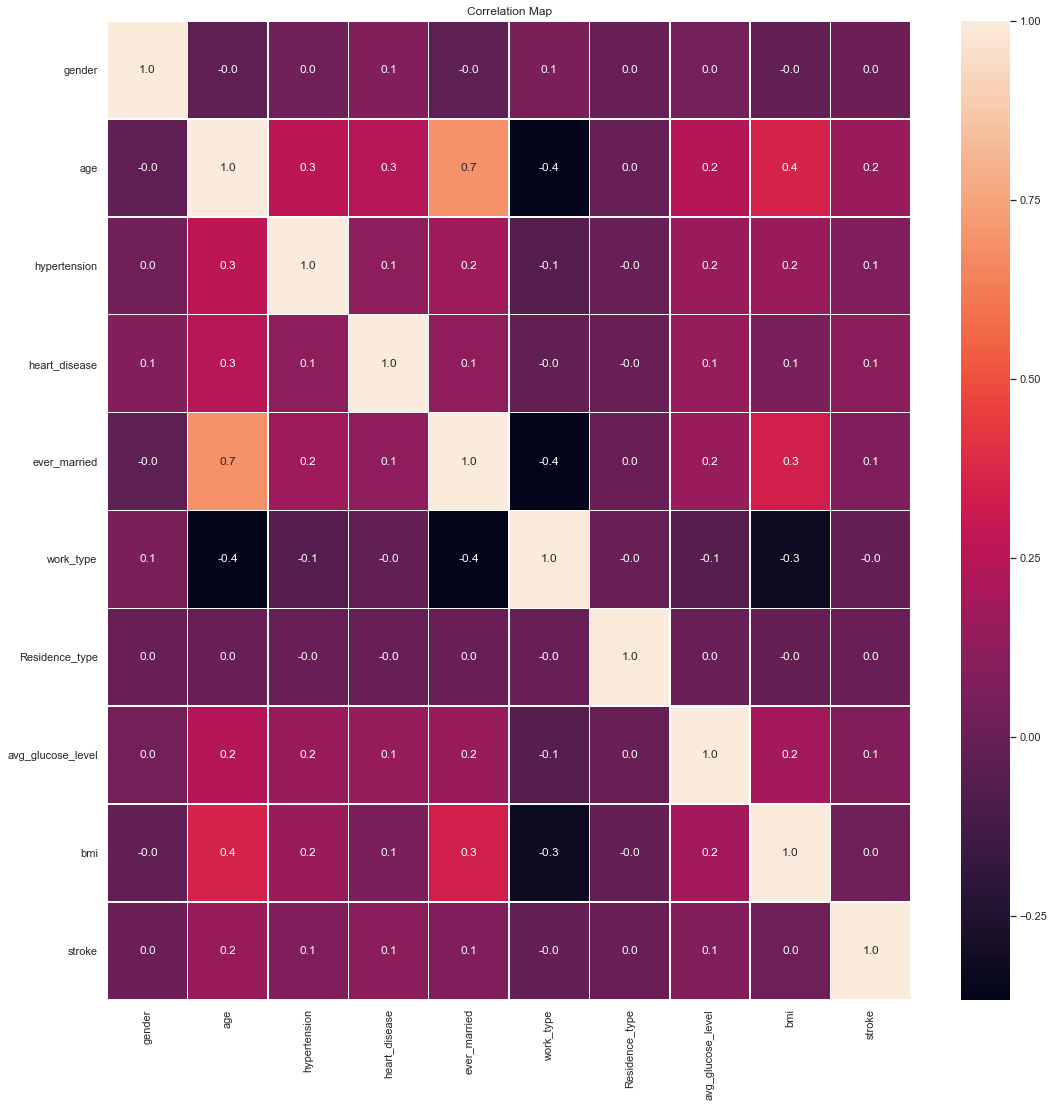

In [259]:
f,ax=plt.subplots(figsize = (18,18))
sns.heatmap(train_data.corr(),annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.savefig('Correlation.png')
plt.show()

##### Checking and Remedy for missing values

In [65]:
missing_data = train_data.isna().sum()
missing_data

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [67]:
# Adding data in 2 dataframes from scratch cause I want to fill NAN values different , wanted to be sure they are not mixed
train_data_W_mean =  pd.read_csv('../Data/train_2v.csv',index_col='id')
train_data_WO_nan =  pd.read_csv('../Data/train_2v.csv',index_col='id')

In [83]:
# Adding mean BMI for nan values in bmi column while for SMOKING_STATUS replacing "never smoked" as its the most occuring value 
train_data_W_mean['bmi'].fillna(train_data_W_mean['bmi'].mean(),inplace = True)
print(train_data_W_mean['smoking_status'].value_counts())
train_data_W_mean['smoking_status'].fillna('never smoked',inplace = True)
train_data_W_mean.shape

never smoked       29345
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64


(43400, 11)

In [88]:
# Dropping NaN values 
train_data_WO_nan= train_data_WO_nan.dropna()
train_data_WO_nan.shape

In [261]:
f_train_data = train_data_W_mean
# f_train_data =train_data_WO_nan

In [262]:
# Handling CAtagorical data
labelEncoder = LabelEncoder()
f_train_data['gender'] = labelEncoder.fit_transform(f_train_data['gender'])
f_train_data['ever_married'] = labelEncoder.fit_transform(f_train_data['ever_married'])
f_train_data['work_type'] = labelEncoder.fit_transform(f_train_data['work_type'])
f_train_data['Residence_type'] = labelEncoder.fit_transform(f_train_data['Residence_type'])
f_train_data['smoking_status'] = labelEncoder.fit_transform(f_train_data['smoking_status'])
f_train_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
30669,1,3.0,0,0,0,4,0,95.12,18.0,1,0
30468,1,58.0,1,0,1,2,1,87.96,39.2,1,0
16523,0,8.0,0,0,0,2,1,110.89,17.6,1,0
56543,0,70.0,0,0,1,2,0,69.04,35.9,0,0
46136,1,14.0,0,0,0,1,0,161.28,19.1,1,0


##### Balanced/Unbalanced

In [263]:
f_train_data['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

In [265]:
# Stroke =1 class oversampled 
ov_Isstroke = f_train_data.loc[train_data['stroke'] == 1].sample(n= 42000,random_state= 9,replace=True)
ov_Nostroke = f_train_data.loc[train_data['stroke'] == 0]
ov_data = pd.concat([ov_Isstroke,ov_Nostroke])
ov_data.stroke.value_counts()

0    42617
1    42000
Name: stroke, dtype: int64

In [267]:
# Stroke =0 class undersampled 
un_Isstroke = f_train_data.loc[train_data['stroke'] == 1]
un_Nostroke = f_train_data.loc[train_data['stroke'] == 0].sample(n= 800,random_state= 9)
un_data = pd.concat([un_Isstroke,un_Nostroke])
un_data.stroke.value_counts()

0    800
1    783
Name: stroke, dtype: int64

In [269]:
training_data = ov_data
# training_data =un_data

training_data = shuffle(training_data)
X = training_data.drop('stroke', axis = 1)
#print(X.shape)
y = training_data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=101)

In [270]:
# intialising basic few layers deep ANN
predictor = Sequential()
predictor.add(Dense(output_dim=9, init='uniform', activation='relu', input_dim=10))
# Adding dropout to prevent overfitting
# predictor.add(Dense(output_dim=8, init='uniform', activation='relu'))
predictor.add(Dropout(p=0.1))
predictor.add(Dense(output_dim=6, init='uniform', activation='relu'))
predictor.add(Dropout(p=0.1))
# predictor.add(Dense(output_dim=4, init='uniform', activation='relu'))
# Adding dropout to prevent overfitting

predictor.add(Dense(output_dim=1, init='uniform', activation='sigmoid'))
predictor.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\noman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=10, units=9, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\noman\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  
C:\Users\noman\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=6, kernel_initializer="uniform")`
  import sys
C:\Users\noman\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  
C:\Users\noman\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  if sys.

In [271]:
predictor.fit(X_train, y_train, batch_size=100, nb_epoch=200)

C:\Users\noman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/200
67693/67693 [==============================] - 3s 40us/step - loss: 0.5640 - acc: 0.7113
Epoch 2/200
67693/67693 [==============================] - 1s 17us/step - loss: 0.5161 - acc: 0.7527
Epoch 3/200
67693/67693 [==============================] - 1s 17us/step - loss: 0.5051 - acc: 0.7570
Epoch 4/200
67693/67693 [==============================] - 1s 17us/step - loss: 0.4997 - acc: 0.7580
Epoch 5/200
67693/67693 [==============================] - 2s 34us/step - loss: 0.4960 - acc: 0.7600
Epoch 6/200
67693/67693 [==============================] - 3s 39us/step - loss: 0.4941 - acc: 0.7594
Epoch 7/200
67693/67693 [==============================] - 2s 24us/step - loss: 0.4939 - acc: 0.7596
Epoch 8/200
67693/67693 [==============================] - 1s 19us/step - loss: 0.4910 - acc: 0.7621
Epoch 9/200
67693/67693 [==============================] - 1s 17us/step - loss: 0.4914 - acc: 0.7623
Epoch 10/200
67693/67693 [==============================] - 1s 18us/step - loss: 0.4913 - a

In [272]:
y_pred = predictor.predict(X_test)
y_pred2 = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred2)
print("Test Accuracy  {}%".format(((cm[0][0] + cm[1][1])/len(y_pred))*100))

Test Accuracy  77.07397778303002%


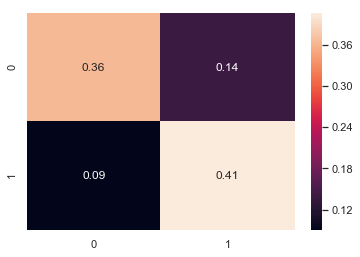

In [273]:
sns.heatmap(cm/len(y_pred2),annot=True)
# plt.savefig('3LayerANNwDropout.png')

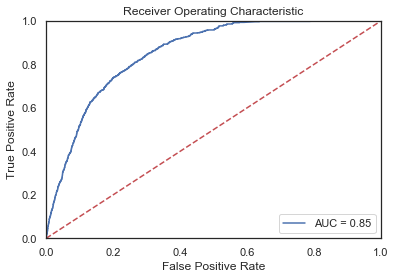

In [274]:
fpr, tpr, threshold = metrics.roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

